In [101]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [102]:
seed = 1
file = open("test.txt", "w")
# for a year of weather data
for x in range(0, 365):
    timpeve = random.randint(0, 1)
    impeve = str(timpeve)
    tdecibel = random.randint(60, 70)
    decibel = str(tdecibel)
    halfa = random.randint(0, 23)
    halfb = random.randint(0, 59)
    if halfa == 0:
        if halfb < 10:
            time = "000" + str(halfb)
        else:
            time = "00" + str(halfb)
    else:
        if halfa < 10:
            if halfb < 10:
                time = "0" + str(halfa) + "0" + str(halfb)
            else:
                time = "0" + str(halfa) + str(halfb)

        elif halfb < 10:
            if halfa < 10:
                time = "0" + str(halfa) + "0" + str(halfb)
            else:
                time = str(halfa) + "0" + str(halfb)
        else:
            time = str(halfa) + str(halfb)
    tfail = random.randint(0, 1)
    fail = str(tfail)
    tanomaly = random.randint(0, 1)
    anomaly = str(tanomaly)
    file.write(impeve + " " + decibel + " " + fail + " " + time + " " + anomaly + "\n")
    random.seed()
file.close()

In [103]:
relevantWeatherData = pd.read_csv('888.csv');
# relevantWeatherData = relevantWeatherData.drop(['WT01', 'WT02','WT03','WT04','WT05','WT06','WT08','WT09', 'AWND', 'TAVG', 'STATION', 'STATION_NAME'], axis = 1)
relevantWeatherData = relevantWeatherData.drop(['SNOW','WT01', 'WT02','WT03','WT04','WT05','WT06','WT08','WT09', 'AWND', 'TAVG', 'STATION', 'STATION_NAME'], axis = 1)

# now we have ['date','prcp', 'snow', 'tmax', and 'tmin' as our features]
# but we want to specify LABC weather data, for this example
# so we make a copy of the original dataframe
# and splice it to only include the weather data from Los Angeles
# these are rows 216 - 581 in our .csv file


labcWeather = relevantWeatherData[:]

# LABC WEATHER
# labcWeather = labcWeather[214:580]

# Long Beach
labcWeather = labcWeather[3127:3494]

# we reset the index of every data value so that it can merge with our pseudo-random dataset
# 2016 was a leap year, so we have 366 entries

labcWeather = labcWeather.reset_index(drop=True)

# labcWeather['SNOW'] = labcWeather['SNOW'].replace([-9999.0], 0.0)


#Add a new column SNR(Signal Noise Ratio) using our formula y = -80x - 20
labcWeather['SNR'] = labcWeather['PRCP'].apply(lambda r: (r * -80) - 20)
print(labcWeather[0:6])


       DATE  PRCP  TMAX  TMIN   SNR
0  20160101  0.00    67    42 -20.0
1  20160102  0.00    66    44 -20.0
2  20160103  0.00    64    43 -20.0
3  20160104  0.00    71    54 -20.0
4  20160105  0.88    61    54 -90.4
5  20160106  0.61    60    48 -68.8


In [104]:
equipmentData = pd.read_csv('test.txt', sep=" ", header = None, names = ['ImpEvent', 'SigLvl', 'NearbyFail', 'Time', 'Anomaly'])

print(equipmentData[::50])

     ImpEvent  SigLvl  NearbyFail  Time  Anomaly
0           0      61           0  1437        0
50          0      65           1  1556        0
100         1      60           1  1040        1
150         0      64           1  2245        1
200         0      63           0   417        0
250         1      68           1    45        1
300         0      64           0   607        1
350         1      62           1  1701        1


In [105]:
# x now contains the weather data in conjunction with the equipment data we created
x = pd.merge(left=labcWeather, right=equipmentData,left_index = True, right_index = True)
x[::91]

,DATE,PRCP,TMAX,TMIN,SNR,ImpEvent,SigLvl,NearbyFail,Time,Anomaly
0,20160101,0.00,67,42,-20.0,0,61,0,1437,0
91,20160401,0.00,70,53,-20.0,1,61,1,621,0
182,20160701,0.00,74,65,-20.0,0,65,1,3,0
273,20160930,0.00,90,68,-20.0,1,65,0,113,0
364,20161230,0.41,63,55,-52.8,1,63,1,436,1


In [106]:
# we have to normalize the values. 
# in this case, we normalize only the values we're going to use. Rain and Signal Power
prcpMax = x['PRCP'].max()
sigMax = x['SigLvl'].max()
snrMax = x['SNR'].max()
snrMin = x['SNR'].min()
tempMax = x['TMAX'].max()
tempMinMax = x['TMIN'].max()
x['NormPRCP'] = x['PRCP'].apply(lambda y: y / prcpMax)
# remove NormSIG since this is random
# x['NormSIG'] = x['SigLvl'].apply(lambda z: z / sigMax)
x['NormTMAX'] = x['TMAX'].apply(lambda u: u / tempMax)
x['NormTMIN'] = x['TMIN'].apply(lambda e: e / tempMinMax)
x['NormSNR'] = x['SNR'].apply(lambda d: (d - snrMin)/ (snrMax - snrMin))

# using the LOG base 10 values of NormPRCP
# and NormSNR

# log(x) not possible bc log(x) where x = 0 means log = -infinity

# log(x + 1)
# x['logPRCP'] = x['NormPRCP'].apply(lambda i: math.log10(i + 1))
# x['logSNR'] = x['NormSNR'].apply(lambda p: math.log10(p + 1))

# 1 + log(x + 1)
# x['logPRCP'] = x['NormPRCP'].apply(lambda i:1 + math.log10(i + 1))
# x['logSNR'] = x['NormSNR'].apply(lambda p:1 + math.log10(p + 1))


# sqrt of x
# x['logPRCP'] = x['NormPRCP'].apply(lambda i: math.sqrt(i))
# x['logSNR'] = x['NormSNR'].apply(lambda p: math.sqrt(p))

# cubed root of x
# x['logPRCP'] = x['NormPRCP'].apply(lambda i: -(-i ** (1. / 3)))

x['logPRCP'] = x['NormPRCP'].apply(lambda i: math.log10(i+0.1))
x['logPRCP2'] = x['NormPRCP'].apply(lambda i: -(-i ** (1. / 3)))


x['logSNR'] = x['NormSNR'].apply(lambda p: -(-p ** (1. / 3)))





In [108]:
x[::90]

,DATE,PRCP,TMAX,TMIN,SNR,ImpEvent,SigLvl,NearbyFail,Time,Anomaly,NormPRCP,NormTMAX,NormTMIN,NormSNR,logPRCP,logPRCP2,logSNR
0,20160101,0.0,67,42,-20.0,0,61,0,1437,0,0.0,0.632075,0.591549,1.0,-1.0,0.0,1.0
90,20160331,0.0,73,48,-20.0,0,67,0,739,1,0.0,0.688679,0.676056,1.0,-1.0,0.0,1.0
180,20160629,0.0,85,67,-20.0,0,66,0,2352,0,0.0,0.801887,0.943662,1.0,-1.0,0.0,1.0
270,20160927,0.0,93,69,-20.0,0,63,0,2251,0,0.0,0.877358,0.971831,1.0,-1.0,0.0,1.0
360,20161226,0.0,63,42,-20.0,1,68,1,2100,1,0.0,0.594340,0.591549,1.0,-1.0,0.0,1.0


<function matplotlib.pyplot.show>

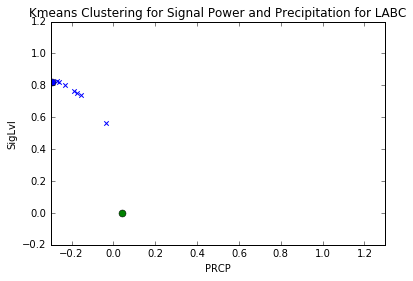

In [109]:
%matplotlib inline
kMeans = KMeans(n_clusters=3)
X = x[['logPRCP', 'logSNR']]
kMeans.fit(X)

# Assigned Labels after clustering: 
labels = kMeans.labels_

# Centers of the clusters:
centers = kMeans.cluster_centers_

plt.figure

for l, c in zip([0,1,2], ['red', 'blue', 'green']):
    
    current_members = (labels == l)
    current_center = centers[l]
    
    plt.scatter(X.iloc[current_members,0], X.iloc[current_members,1], color = c, marker='x')
    
    plt.plot(current_center[0], current_center[1], 'o', markerfacecolor = c,
            markeredgecolor = 'k', markersize=7)
    
plt.xlim([-0.3,1.3])

    
plt.xlabel('PRCP')
plt.ylabel('SigLvl')
plt.title('Kmeans Clustering for Signal Power and Precipitation for LABC')

plt.show

In [110]:
# std and mean for NORMALIZED values
# list which features to get std and mean
# for example, it wouldnt make sense to get std and mean of date and time
# stdMeanFeats = ['PRCP', 'TMAX','TMIN','SigLvl', 'NormPRCP', 'NormSIG', 'NormSNR']

# we can only use normalized values for a normal distribution of data
stdMeanFeats = ['NormTMIN', 'logPRCP', 'logSNR', 'logPRCP2']
# stdMeanFeats = ['logPRCP', 'logSNR']
print("Standard Deviation:")
print(x[stdMeanFeats].std())

print("\nMean:")
print(x[stdMeanFeats].mean())



#NDvalues stores the normal distribution values of PRCP, then SNOW, then TMAX, etc.
i = 0
# NDvalues = [0, 0, 0, 0, 0, 0, 0]
NDvalues = [0,0,0,0]
for name in stdMeanFeats:
    z = 0
    e = 2.71
    denominator = math.sqrt(2 * (math.pow(x[name].std(), 2)) * math.pi) 
    numeratorOfPower = math.pow((z - x[name].mean()), 2)
    denominatorOfPower = 2 * math.pow(x[name].std(), 2)
    power = numeratorOfPower / denominatorOfPower
    power *= -1
    finalbase = e / denominator
    NDvalues[i] = math.pow(finalbase, (power))
    i += 1

i = 0
print('\n')
print('Normal Distribution Values \n')
for value in NDvalues:
    print(str(stdMeanFeats[i]) + '      ' + str(NDvalues[i]))
    i += 1
finalValue = 1
for number in NDvalues:
    finalValue *= number
print()
print('Probability: ' + str(finalValue))


Standard Deviation:
NormTMIN    0.101986
logPRCP     0.158511
logSNR      0.065885
logPRCP2    0.172847
dtype: float64

Mean:
NormTMIN    0.808875
logPRCP    -0.959996
logSNR      0.988846
logPRCP2    0.050000
dtype: float64


Normal Distribution Values 

NormTMIN      5.637689284469533e-33
logPRCP      5.107238997033816e-16
logSNR      1.3924012034012642e-137
logPRCP2      0.9261616394304648

Probability: 3.7131158281243633e-185


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017AAC7530F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000017AAE4282E8>]], dtype=object)

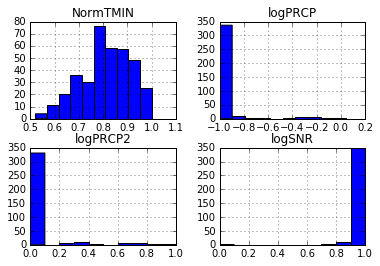

In [111]:
%matplotlib inline

plt.figure

x[stdMeanFeats].hist(bins=10)